# Keras CNN

A convolutional neural network written in keras with tensorflow backend.

## Imports

In [1]:
%matplotlib inline
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit

from fetch_mnist import fetch_mnist

np.random.seed(1)

## Constants

In [2]:
# Data parameters
num_labels = 10 # Number of different types of labels (1-10)
width, height = 28, 28 # width / height of the image
depth = 1 # Number of colors in the image (greyscale)

# Training Parameters
num_steps = 2000   # Number of training steps to run
test_size = 10000 # Test data set size
valid_size = 10000 # Validation data set size
train_size = 60000 - valid_size # Size of the training set
batch_size = 100 # Stochastic Gradient Descent batch size

# CNN Parameters
kernel_size = 5 # Convolutional Kernel size
kernel_depth = 32 # Convolutional Kernel depth size == Number of Convolutional Kernels
num_hidden = 1024 # Number of hidden neurons in the fully connected layer

# Optimization parameters
learning_rate = 0.001 # Learning rate

## Data

We use the custom MNIST data fetcher from `fetch_mnist.py`.

As a preprocessing step, the labels are converted to a one-hot encoded sparse matrix. [One hot encoding](https://en.wikipedia.org/wiki/One-hot) is just a way of replacing each integer in the label vector with a row of zeros, except at the position specified by the integer, where you put a 1.

Note that the inverse transformation of the one-hot encoding can always be performed by taking the `argmax` along `axis=1`.

Secondly, the image values are specified by an integer between 0 and 255. We convert these pixel values to a float between 0 and 1.

In [3]:
train_data, test_data = fetch_mnist()
data = np.vstack([train_data, test_data])
np.random.shuffle(data)

train_data = data[:-test_size-valid_size]
valid_data = data[-test_size-valid_size:-test_size]
test_data  = data[-test_size:]

def get_values_labels(data):
    labels = np.int32(data[:,0])
    labels_onehot = np.zeros((len(labels), num_labels))
    labels_onehot[np.arange(len(labels)),labels] = 1
    values = np.float32(data[:,1:]).reshape(-1, height, width, depth)/255
    return values, labels, labels_onehot

train_values, train_labels, train_labels_onehot = get_values_labels(train_data)
valid_values, valid_labels, valid_labels_onehot = get_values_labels(valid_data)
test_values, test_labels, test_labels_onehot = get_values_labels(test_data)

print(f'train data shape:\t\t{train_values.shape}')
print(f'train labels (one-hot) shape:\t{train_labels_onehot.shape}')

train data shape:		(50000, 28, 28, 1)
train labels (one-hot) shape:	(50000, 10)


We can visualize the different digits by writing a visualization function that reshapes the 784D train and test values into a 28x28 grid:

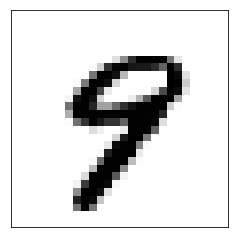

In [4]:
def show_digit(digit_array):
    plt.imshow(digit_array.reshape(height, width), cmap='Greys')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    
show_digit(train_values[31])

## Model

Let's now build a network with two convolutional layers, followed by two fully connected layers.

We choose a 4 layered network consisting of 2 convolutional layers, followed by a fully connected hidden layer  and an output layer.

We initialize the layerssuch that the kernel size of the second convolutional layer is twice that of the kernel size of the first convolutional layer.

In [5]:
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten

In [6]:
model = keras.Sequential([
    Conv2D(kernel_depth, kernel_size, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), padding='same'),
    Conv2D(2*kernel_depth, kernel_size, padding='same', activation='relu'),
    MaxPool2D(pool_size=(2,2), padding='same'),
    Flatten(),
    Dense(num_hidden, activation='relu'),
    Dense(num_labels, activation='softmax'),
])

model.compile(
    loss=keras.losses.categorical_crossentropy,
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy'],
)

## Train

In [7]:
%%time
history = keras.callbacks.History()
model.fit(
    x=train_values,
    y=train_labels_onehot,
    batch_size=batch_size,
    epochs=4,
    validation_data=(valid_values, valid_labels_onehot),
    verbose=1,
    callbacks=[history],
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/4
50000/50000 [==============================] - 6s 126us/step - loss: 0.1333 - acc: 0.9579 - val_loss: 0.0465 - val_acc: 0.9869
Epoch 2/4
50000/50000 [==============================] - 5s 101us/step - loss: 0.0385 - acc: 0.9876 - val_loss: 0.0497 - val_acc: 0.9852
Epoch 3/4
50000/50000 [==============================] - 5s 101us/step - loss: 0.0259 - acc: 0.9913 - val_loss: 0.0408 - val_acc: 0.9872
Epoch 4/4
50000/50000 [==============================] - 5s 101us/step - loss: 0.0188 - acc: 0.9935 - val_loss: 0.0340 - val_acc: 0.9902
CPU times: user 19.3 s, sys: 4.17 s, total: 23.5 s
Wall time: 21.6 s


Training History:

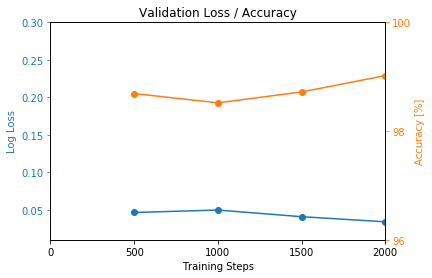

In [8]:
loss = history.history['val_loss']
acc = 100*np.array(history.history['val_acc'])
steps = np.arange(1, len(loss)+1)*(train_size//batch_size)

fig, ax_loss = plt.subplots()
ax_acc = ax_loss.twinx()

plt.sca(ax_acc)
plt.plot(steps, acc, '-o', color='C1')
plt.ylabel('Accuracy [%]', color='C1');
plt.tick_params('y', colors='C1')
plt.ylim(96,100)
plt.yticks([96,98,100])

plt.sca(ax_loss)
plt.plot(steps, loss, '-o', color='C0')
plt.ylabel('Log Loss', color='C0');
plt.tick_params('y', colors='C0')
plt.ylim(0.01, 0.3)

plt.xlim(0, max(steps))
plt.xticks([0,num_steps//4, num_steps//2, 3*num_steps//4, num_steps])
plt.xlabel('Training Steps')
plt.title('Validation Loss / Accuracy')
plt.show()

## Test

Finally, the accuracy on the test set can be evaluated:

In [9]:
_, test_accuracy = model.test_on_batch(test_values, test_labels_onehot)
print(f'Test Accuracy = {100*test_accuracy:5.2f}')

Test Accuracy = 99.12


Visualize an example

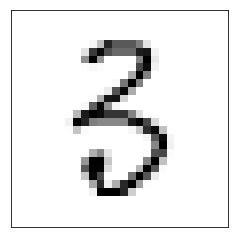

prediction=3	target=3


In [10]:
N = 315
show_digit(test_values[N])
prediction = np.argmax(model.predict(test_values[N:N+1]))
print(f'prediction={prediction}\ttarget={test_labels[N]}')